<center>
<h1><b>Categorizzazione dei video di <b style="color:red">You</b>tube</b></h1>
<h3><i>Analisi del testo - classificazione multiclasse</i></h3>
<a href="https://www.antoniopelusi.com">Antonio Pelusi</a>
<p>Matricola: <b>182267</b></p>
<a href="mailto:257241@studenti.unimore.it">257241@studenti.unimore.it</a>
</center>

---

# **Abstract**
Classificazione dei video di Youtube utilizzando il loro titolo e la loro descrizione.

Nella sezione **2 - Progettazione** verrà approfondito il progetto e le fasi che dovranno essere affrontate per il suo sviluppo.

Nella sezione **8 - Analisi esplorativa** verranno effettuate le scelte tecniche librerie, algoritmi e tecniche che dovranno essere utilizzate nei processi di training e testing del modello.

Di seguito un breve elenco dei principali metodi, algoritmi e tecniche utilizzati:

Librerie di text mining utilizzate:
- **NLTK**
- **SciKit Learn**

Algoritmi testati:
- *Naive Bayes*, nella sua implementazione presente nella libreria **NLTK**
- *Naive Bayes*, nella sua implementazione presente nella libreria **SciKit Learn**
- *SGD Classifier*,nella sua implementazione presente nella libreria **SciKit Learn**

Tecniche utilizzate:
- pulizia generale del testo
- stemming delle parole
- tokenizzazione
- cross-validation
- grid-search

---

# **Indice**

1. **[Obiettivo](#1---obiettivo)**

2. **[Progettazione](#2---progettazione)**

3. **[Inizializzazione](#3---inizializzazione)**

4. **[Raccolta dati](#4---raccolta-dei-dati)**

5. **[Pulizia del dataset](#5---pulizia-del-dataset)**

6. **[Pulizia del testo](#6---pulizia-del-testo)**

7. **[Tokenizzazione](#7---tokenizzazione)**

8. **[Analisi esplorativa](#8---analisi-esplorativa)**

    - **Naive Bayes**
    
    - **SGD Classifier**

9. **[NLTK - Naive Bayes](#9---nltk---naive-bayes)**

    - **Creazione train set e test set**

    - **Training**

    - **Testing**
    
    - **Raccolta dei risultati**

10. **[SKLearn - Naive Bayes](#10---sklearn---naive-bayes)**

    - **Creazione train set e test set**

    - **Training**

    - **Testing**
    
    - **Raccolta dei risultati**

11. **[SKLearn - SGD Classifier](#11---sklearn---sgd-classifier)**

    - **Creazione train set e test set**

    - **Training**

    - **Testing**
    
    - **Raccolta dei risultati**

12. **[Analisi conclusiva](#12---analisi-conclusiva)**

---

# 1 - **Obiettivo**

L'obiettivo del seguente progetto è quello di sviluppare un modello di text mining capace di assegnare la categoria corretta ad un video Youtube.

Si tratta quindi di un problema di classificazione multi-classe.

---

# 2 - **Progettazione**

Essendo un modello di text mining, le uniche risorse testuali che un video su Youtube possiede sono titolo e descrizione.

Ogni video potrà essere classificato in una delle seguenti 9 categorie:
- **travel**
- **science and technology**
- **food**
- **manufacturing**
- **history**
- **art and music**
- **nature**
- **sports**
- **adventure**

L'intero processo sarà diviso nelle seguenti macro aree:

- **Raccolta dei dati**: per questo progetto verrà utilizzato un dataset contenente ~30k records, ciascuno contenente le informazioni di un video di Youtube, tra cui titolo, descrizione e categoria

- **Pulizia del dataset**: consiste nella rimozione dei records che hanno qualche informazione mancante. infatti questi record potrebbero avere una influenza negativa nella fase di training, falsando l'accuratezza in fase di testing

- **Pulizia del testo**: questa fase applicherà alle informazioni grezze (titolo e descrizione) le seguenti modifiche:
  
    - unione dei titoli e delle descrizioni (al fine di avere un'unica fonte di informazioni)
  
    - Rimozione codice *html*, *urls*, *caratteri speciali* e *stopwords*
  
    - Stemming del testo (processo di riduzione della forma flessa di una parola alla sua forma radice, detta *tema*)

- **Tokenizzazione**: consiste nella divisione del testo grezzo in unità più piccole, detti *token*

- **Analisi esplorativa**: in questa fase verrà studiato approssimativamente il dataset e la sua struttura. Verranno inoltre scelti i metodi che dovranno essere utilizzati nella fase di training, tenendo conto sia dell'obiettivo che del dataset

- Per ogni metodo di training testato, si ripeteranno le seguenti fasi:

    - **Creazione train set e test set**: il dataset verrà diviso in due parti: una parte verrà utilizzata per la fase di training, l'altra per la fase di testing

    - **Training**: in questa fase avverrà l'addestramento del modello con i dati del training set con il metodo scelto nella fase di analisi esplorativa

    - **Testing**: a questo punto sarà possibile valutare l'accuratezza del modello

    - **Raccolta dei risultati**: in questa fase verranno raccolte le accuratezze ottenute dal metodo di training. Questi dati verranno messi a confronto nella fase di analisi conclusiva

È possibile modificare la seguente variabile globale per modificare la percentuale di rapporto *train_set*/*test_set* che verrà usata per tutti i test.

Ad esempio se inserisco il valore 80, l'80% del dataset totale verrà assegnato al *train_set*, mentre il rimanente 20% verrà utilizzato come *test_set*:

In [1]:
# - - - - - - - - - - - - - #
train_set_percentage = 80
# - - - - - - - - - - - - - #

---

# 3 - **Inizializzazione**

Importazione librerie necessarie:

In [2]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import nltk
import re
import random
from bs4 import BeautifulSoup
from nltk.tokenize.toktok import ToktokTokenizer
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
 
import warnings
warnings.simplefilter(action='ignore')

Importazione del dataset:

In [3]:
yt = pd.read_csv('youtube-videos.csv')

print('Numero di records:', yt.shape[0])
print('Numero di colonne:', yt.shape[1])
yt.head(10)

Numero di records: 29245
Numero di colonne: 7


,Unnamed: 0.1,Category,Description,Title,Unnamed: 0,Video Id,file
0,0,travel,DISCLAIMER* Please do not ride elephants when ...,Welcome to Bali | Travel Vlog | Priscilla Lee,0,i9E_Blai8vk,Collected_data_raw1.csv
1,1,travel,Had the most amazing experience in Finland for...,FINLAND VACATION: TRAVEL VLOG,1,UBvJKs9eW3I,Collected_data_raw1.csv
2,2,travel,Hello loves Today's video is the Vlog of my tr...,MYKONOS GREECE TRAVEL VLOG 2020 | Living our ...,2,jeIQ_Z35HZ4,Collected_data_raw1.csv
3,3,travel,Thank you so much for watching! I hope you fou...,"TRAVEL VLOG: SANTORINI, GREECE",3,EthqIhPtd2I,Collected_data_raw1.csv
4,4,travel,Las Vegas Travel Vlog 2020 - Pandemic Version....,Las Vegas Travel Vlog 2020 | Pandemic Edition,4,X0F0Dh8ut3U,Collected_data_raw1.csv
5,5,travel,Follow along a travel day in my life!! LINKS: ...,"TRAVEL DAY VLOG: Airport Essentials, What&#39;...",5,USGN-aTzlG4,Collected_data_raw1.csv
6,6,travel,i still cant believe they had philz on the pla...,just a travel vlog. nothing special.,6,wfIWTD30gCw,Collected_data_raw1.csv
7,7,travel,This past March of 2020 we visited The Maldive...,LUXURY MALDIVES EXPERIENCE | TRAVEL VLOG,7,FaeQtn3-h4w,Collected_data_raw1.csv
8,8,travel,INSTA: https://instagram.com/annaheid?igshid=x...,travel vlog: airport at 4 am on CHRISTMAS!!,8,DD-Znv9vV5s,Collected_data_raw1.csv
9,9,travel,We are selecting one person who makes a purcha...,Traveling to the Happiest Country in the World!!,9,Qmi-Xwq-MEc,Collected_data_raw1.csv


---

# 4 - **Raccolta dei dati**

Il dataset è stato scaricato dal sito [kaggle.com](https://www.kaggle.com/) ed è consultabile e scaricabile **[QUI](https://www.kaggle.com/datasets/aashishbidap/youtube-api-data-for-text-categorization)**.

Come da traccia del progetto, è stato scelto appositamente un dataset che privo di alcun notebook o discussione associato ad esso.

---

# 5 - **Pulizia del dataset**

Rimuovo le colonne superflue alla classificazione per questioni di efficienza:

In [4]:
del yt['file']
del yt['Unnamed: 0']
del yt['Unnamed: 0.1']

print('Numero di records:', yt.shape[0])
print('Numero di colonne:', yt.shape[1])
yt.head(10)

Numero di records: 29245
Numero di colonne: 4


,Category,Description,Title,Video Id
0,travel,DISCLAIMER* Please do not ride elephants when ...,Welcome to Bali | Travel Vlog | Priscilla Lee,i9E_Blai8vk
1,travel,Had the most amazing experience in Finland for...,FINLAND VACATION: TRAVEL VLOG,UBvJKs9eW3I
2,travel,Hello loves Today's video is the Vlog of my tr...,MYKONOS GREECE TRAVEL VLOG 2020 | Living our ...,jeIQ_Z35HZ4
3,travel,Thank you so much for watching! I hope you fou...,"TRAVEL VLOG: SANTORINI, GREECE",EthqIhPtd2I
4,travel,Las Vegas Travel Vlog 2020 - Pandemic Version....,Las Vegas Travel Vlog 2020 | Pandemic Edition,X0F0Dh8ut3U
5,travel,Follow along a travel day in my life!! LINKS: ...,"TRAVEL DAY VLOG: Airport Essentials, What&#39;...",USGN-aTzlG4
6,travel,i still cant believe they had philz on the pla...,just a travel vlog. nothing special.,wfIWTD30gCw
7,travel,This past March of 2020 we visited The Maldive...,LUXURY MALDIVES EXPERIENCE | TRAVEL VLOG,FaeQtn3-h4w
8,travel,INSTA: https://instagram.com/annaheid?igshid=x...,travel vlog: airport at 4 am on CHRISTMAS!!,DD-Znv9vV5s
9,travel,We are selecting one person who makes a purcha...,Traveling to the Happiest Country in the World!!,Qmi-Xwq-MEc


Controllo se il dataset è completo:

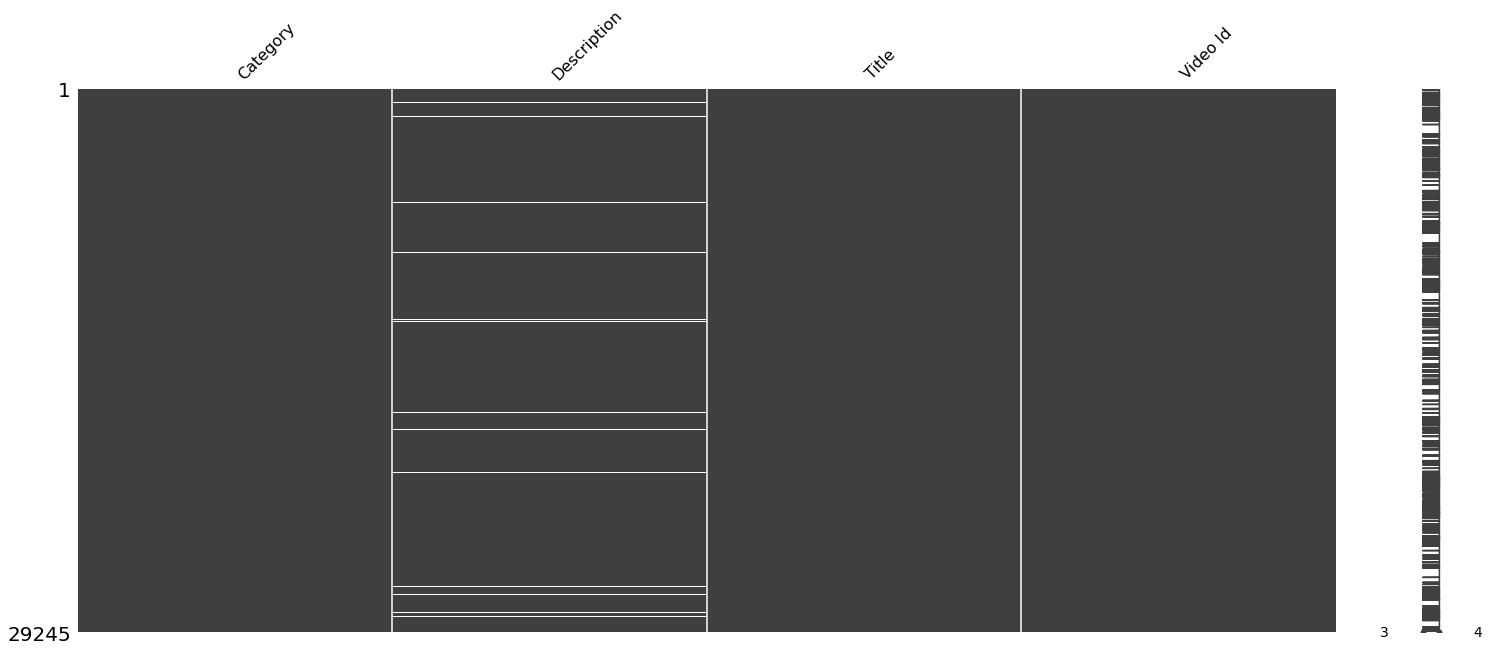

In [5]:
msno.matrix(yt);

È possibile notare che vi sono video che non presentano la descrizione. Poiché il campo della descrizione è necessario, si può procedere con la rimozione di tali records:

In [6]:
yt.dropna(axis=0, how='any',inplace=True)

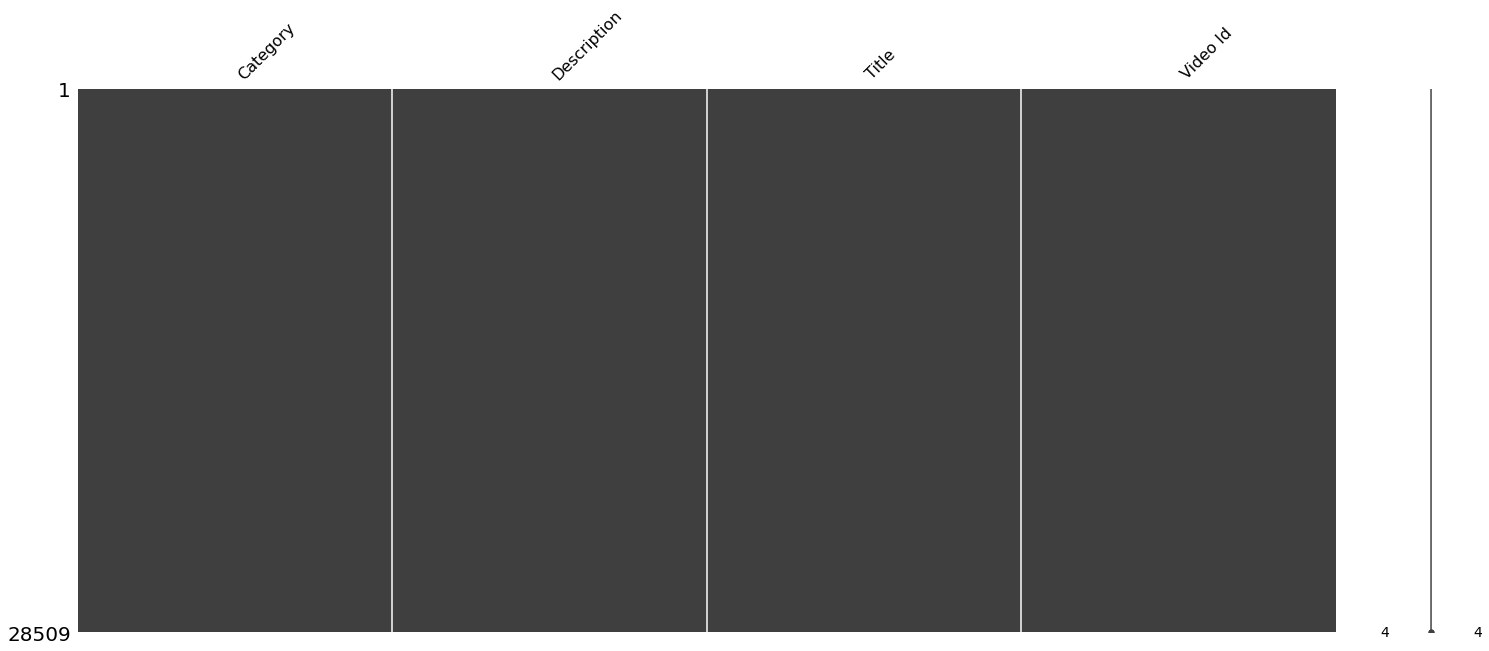

In [7]:
msno.matrix(yt);

A questo punto, il focus può passare sulla pulizia del testo, in modo tale da estrarre da quest'ultimo delle informazioni utili per addestrare il modello nella maniera più efficiente possibile.

---

# 6 - **Pulizia del testo**

Unisco le colonne Title e Description in una nuova colonna chiamata Tokens:

In [8]:
yt['Tokens'] = yt['Title'] + ' ' + yt['Description']

del yt['Title']
del yt['Description']

Rimuovo elementi superflui quali codice html, urls, caratteri speciali e stopwords:

In [9]:
def remove_html(text):
    bs = BeautifulSoup(text, "html.parser")
    return bs.get_text()

def remove_urls(text):
    return re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def remove_stopwords(text, is_lower_case=False):
    stopword_list = nltk.corpus.stopwords.words('english')
    tokenizer = ToktokTokenizer()

    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

yt['Tokens'] = yt['Tokens'].apply(remove_html)
yt['Tokens'] = yt['Tokens'].apply(remove_urls)
yt['Tokens'] = yt['Tokens'].apply(remove_special_characters)
yt['Tokens'] = yt['Tokens'].apply(remove_stopwords)

Stemming del testo (riduco ogni parola in forma flessa nella sua radice):

In [10]:
def stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

yt['Tokens'] = yt['Tokens'].apply(stemmer)

---

# 7 - **Tokenizzazione**

Separo il testo in parole singole, detti *token*:

In [11]:
yt['Tokens'] = yt['Tokens'].apply(nltk.word_tokenize)

Il dataset è pronto alla fase di analisi esplorativa.

---

# 8 - **Analisi esplorativa**

Ricavo le dimensioni del dataset:

In [12]:
print('Numero di records totali:', len(yt['Tokens']))
print('Numero di token totali:', sum([len(i) for i in yt['Tokens']]))

Numero di records totali: 28509
Numero di token totali: 606574


Struttura:

In [13]:
yt.head()

,Category,Video Id,Tokens
0,travel,i9E_Blai8vk,"[welcom, bali, travel, vlog, priscilla, lee, d..."
1,travel,UBvJKs9eW3I,"[finland, vacat, travel, vlog, amaz, experi, f..."
2,travel,jeIQ_Z35HZ4,"[mykono, greec, travel, vlog, 2020, live, best..."
3,travel,EthqIhPtd2I,"[travel, vlog, santorini, greec, thank, much, ..."
4,travel,X0F0Dh8ut3U,"[la, vega, travel, vlog, 2020, pandem, edit, l..."


I *tokens* sono organizzati in liste, e ad ogni lista di token vi è associata una categoria.

Conto ed elenco tutte le categorie:

In [14]:
categories = yt['Category'].unique()

print('Numero di categorie:', categories.size, '\n')

for i in categories:
    print('-', i)

Numero di categorie: 9 

- travel
- science and technology
- food
- manufacturing
- history
- art and music
- nature
- sports
- adventure


Confronto tra i video per categoria:

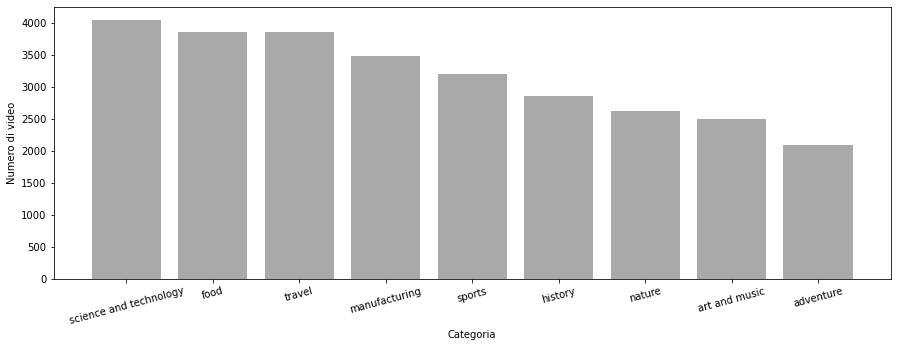

In [15]:
c = yt['Category'].value_counts()

plt.figure(figsize=(15,5))
plt.bar(c.index, c.values, color = 'darkgrey')
plt.xlabel('Categoria')
plt.ylabel('Numero di video')
plt.xticks(rotation=15)
plt.show();

Esplorato il dataset, si possono estrarre le seguenti informazioni, utili per la scelta dei metodi di apprendimento da applicare:

- nel dataset sono presenti ~30k records, con un totale di ~600k token. Nonostante sia un numero abbastanza alto di informazioni, per istruire nella maniera più efficiente possibile il modello in questione, sarà necessario applicare sfruttare tecniche particolari nella fase di training, come la **cross-validation**, che consiste nell'effettuare più iterazioni sullo stesso dataset, prendendo di volta in volta porzioni diverse del dataset da usare come training set e test set.

- per la scelta valori ottimali degli iperparametri si può utilizzare la tecnica del **grid-search**

- il dataset contiene video di categorie sparse uniformemente, quindi non dovrebbero esserci problemi di overfitting (o underfitting) su determinate categorie. Si prevede una accuratezza inferiore per i video della categoria *adventure*, poiché i records totali di quest'ultima sono circa la metà di quelli della categoria *science and technology*

- poiché nel dataset i records dei video della stessa cateogria sono consecutivi, sarà necessario effettuare uno shuffle dei documenti prima di eseguire la fase di training, a prescindere dalla presenza del **cross-validation**.

Per quanto riguarda la scelta dei metodi per la classificazione, vi sono numerose alternative. 

In questo progetto, ho deciso di testare i seguenti algoritmi:

## | Naive Bayes
Algoritmo semplice e veloce, che considera indipendenti tra loro le varie caratteristiche (*features*) del modello, quindi non considerando eventuali correlazioni tra esse.

È un algoritmo probabilistico che calcola la probabilità di ogni etichetta per un determinato oggetto osservando le sue caratteristiche. Poi sceglie l'etichetta con probabilità maggiore.

Per calcolare la probabilità delle singole etichette usa il *teorema di Bayes*:
>**P**(**A**|**E**) = [**P**(**E**|**A**) * **P**(**A**)] / **P**(**E**)

in cui:
- **P**(**A**) è la probabilità a priori di **A**, ovvero senza considerare **P**(**E**)

- **P**(**E**) è la probabilità a priori di **E**, ovvero senza considerare **P**(**A**)

- **P**(**A**|**E**) è la probabilità condizionata dell'evento **A** considerando le informazioni sull'evento **E**

- **P**(**E**|**A**) è la probabilità condizionata dell'evento **E** considerando le informazioni sull'evento **A**

Verranno testate sia l'implementazione di questo algoritmo presente nella libreria *NLTK* che quella presente in *SciKit Learn*

## | SGD Classifier
**S**tochastic **G**radient **D**escend è un classificatore lineare ottimizzato dal gradiente stocastico discendente.

Generalizzando, il gradiente stocastico ha il compito di minimizzare una funzione di costo. Per questo motivo, ha molteplici applicazioni nel campo del machine learning, tra cui appunto la classificazione multiclasse per quanto riguarda il text mining.

verrà testata la sua implementazione di questo algoritmo presente nella libreria *SciKit Learn*.

Di seguito sono elencati i tre algoritmi con cui verrà separatamente istruito il dataset:

- <b style="color:slateblue;">Naive Bayes</b>, nella sua implementazione presente nella libreria <b style="color:slateblue;">NLTK</b>

- <b style="color:green;">Naive Bayes</b>, nella sua implementazione presente nella libreria <b style="color:green;">SciKit Learn</b>

- <b style="color:tomato;">SGD Classifier</b>, nella sua implementazione presente nella libreria <b style="color:tomato;">SciKit Learn</b>

Tutti e tre gli algoritmi eseguiranno su *train_set* e *test_set* di eguali dimensioni.

Inoltre sono stati testati manualmente i tre algoritmi con diverse dimensioni di *train_set* e *test_set*, raccogliendo di volta in volta le percentuali di accuratezza calcolate.

Saranno consultabili sia nelle sezioni di raccolta risultati che nell'analisi conclusiva. 

---

# 9 - **NLTK** - *Naive Bayes*

## | Creazione train set e test set
**NLTK** - *Naive Bayes*

Procedo con la creazione un sistema che permetta di dividere il dataset tra train set e test set usando una percentuale inserita dall'utente:

In [16]:
test_set_percentage = 100-train_set_percentage

total_size = yt.shape[0]

train_set_size = total_size//100*train_set_percentage

In questo modo, cambiando il valore della variabile **train_set_percentage** è possibile cambiare la percentuale di dataset che verrà dedicata al *train_set*, e la cui parte restante verrà utilizzata come *test set*.

A questo punto è possibile creare il **feature_set** che conterrà le informazioni relative alle parole contenute in ciascun titolo/descrizione dei video.

Il **feature_set** verrà poi diviso in **train_set** e **test_set** a seconda del rapporto percentuale precedentemente inserito dall'utente:

In [17]:
docs = [(yt['Tokens'].to_list()[i], yt['Category'].to_list()[i]) for i in range(len(yt))]

#shuffle dei documenti per evitare overfitting o underfitting
random.shuffle(docs)

allWords = [word.lower() for doc in docs for word in doc[0]]

vocabulary = [w[0] for w in nltk.FreqDist(allWords).most_common(3000)]

def docFeatures(document):
    docWords = set(document)
    features = {}
    for word in vocabulary:
        features['contains({})'.format(word)] = (word in docWords)
    return features

# creo il set di feature contenente l'associazione di ogni gruppo di token con la propria categoria
feature_sets = [(docFeatures(d), c) for (d,c) in docs]

# divido il feature_set in train_set e test_set a seconda del rapporto percentuale scelto
train_set = feature_sets[:train_set_size]
test_set = feature_sets[train_set_size:]

Controllo le dimensioni di **train_set** e **test_set**:

In [18]:
print('Dimensione totale del dataset:', total_size, f'({train_set_percentage+test_set_percentage}%)')
print('Dimensione train set:', len(train_set), f'({train_set_percentage}%)')
print('Dimensione test set:', len(test_set), f'({test_set_percentage}%)')

Dimensione totale del dataset: 28509 (100%)
Dimensione train set: 22800 (80%)
Dimensione test set: 5709 (20%)


## | Training
**NLTK** - *Naive Bayes*

In [19]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

## | Testing
**NLTK** - *Naive Bayes*

In [20]:
print('Accuratezza: ~' + str(int(nltk.classify.accuracy(classifier, test_set)*100)) + '%')

Accuratezza: ~88%


Il valore ottenuto rappresenta la percentuale di accuratezza calcolata testando il modello istruito sul **train_set** ed eseguito sul **test_set**.

Visualizzo ora le 10 informazioni più utili che il modello ha imparato autonomamente:

In [21]:
classifier.show_most_informative_features(10)

Most Informative Features
    contains(archaeolog) = True           histor : scienc =   1298.1 : 1.0
        contains(travel) = True           travel : manufa =   1105.6 : 1.0
         contains(print) = True           manufa : travel =   1080.6 : 1.0
         contains(robot) = True           scienc : sports =    985.8 : 1.0
            contains(3d) = True           manufa : travel =    788.4 : 1.0
        contains(delici) = True             food : nature =    760.2 : 1.0
       contains(ancient) = True           histor : food   =    659.6 : 1.0
          contains(food) = True             food : sports =    653.5 : 1.0
     contains(deadliest) = True           advent : travel =    549.4 : 1.0
 contains(archaeologist) = True           histor : nature =    424.0 : 1.0


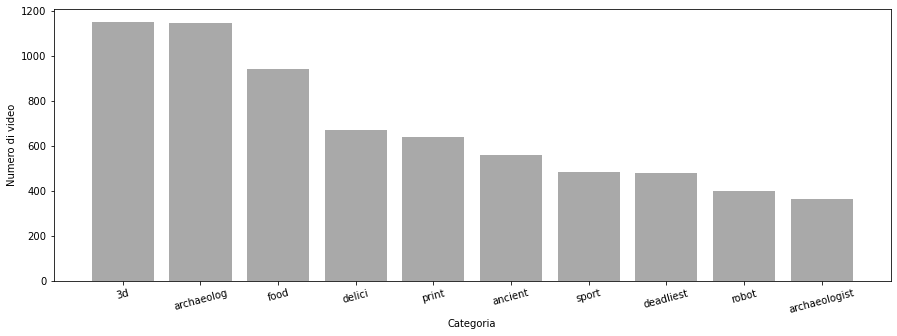

In [22]:
d = {'3d':1151, 'archaeolog':1148, 'food':941, 'delici':668, 'print':640,  'ancient':560, 'sport':485, 'deadliest':478, 'robot':399, 'archaeologist':362}
plt.figure(figsize=(15,5))
plt.bar(d.keys(), d.values(), color = 'darkgrey')
plt.xlabel('Categoria')
plt.ylabel('Numero di video')
plt.xticks(rotation=15)
plt.show();

## | Raccolta dei risultati
**NLTK** - *Naive Bayes*

Di seguito una tabella contenente le percentuali di accuratezza a seconda delle diverse combinazioni di training_set/test_set testate:

|train set size (%)|test set size (%)|accuracy|
|:-:|:-:|:-:|
|14250 (50%)|14259 (50%)|~88%|
|17100 (60%)|11409 (40%)|~88%|
|19950 (70%)|8559 (30%)|~88%|
|22800 (80%)|5709 (20%)|~89%|
|25650 (90%)|2859 (10%)|~89%|

---

# 10 - **SKLearn** - *Naive Bayes*

## | Creazione train set e test set
**SKLearn** - *Naive Bayes*

La libreria *SKLearn* necessita degli stessi dati ma in un formato diverso.

A differenza di *NLTK* che richiedeva una lista di liste di token, *SKLearn* richiede una lista di stringhe, in cui ogni stringa contiene tutti i token.

Procedo con il riformattare i dati nel formato richiesto:

In [23]:
categories = ['travel', 'science and technology', 'food', 'manufacturing', 'history', 'art and music', 'nature', 'sports', 'adventure']

old_x = [i for i in yt['Tokens'].to_list()]

x = ['' for _ in old_x]

w = 0
for i in old_x:
    for j in i:
        x[w] += j + ' '
    w+=1
    
y = [None for i in range(28509)]

j = 0
for i in yt['Category'].to_list():
    if i == 'travel':
        y[j] = 0
    if i == 'science and technology':
        y[j] = 1
    if i == 'food':
        y[j] = 2
    if i == 'manufacturing':
        y[j] = 3
    if i == 'history':
        y[j] = 4
    if i == 'art and music':
        y[j] = 5
    if i == 'nature':
        y[j] = 6
    if i == 'sports':
        y[j] = 7
    if i == 'adventure':
        y[j] = 8
    j+=1

Ricalcolo i le dimensioni del *train_set* e del *test_set*:

In [24]:
test_set_percentage = 100-train_set_percentage

total_size = len(x)

train_set_size = total_size//100*train_set_percentage

Effettuo lo shuffle dei documenti, per poi dividere il dataset in *train_set* e *test_set*:

In [25]:
#suffle dei documenti
temp = list(zip(x, y))

random.shuffle(temp)

x, y = zip(*temp)
x, y = list(x), list(y)

#divido il dataset in train set e test set
train_s = x[:train_set_size]
test_s = x[train_set_size:]

train_t = y[:train_set_size]
test_t = y[train_set_size:]

Controllo le dimensioni di **train_set** e **test_set**:

In [26]:
print('Dimensione totale del dataset:', total_size, f'({train_set_percentage+test_set_percentage}%)')
print('Dimensione train set:', len(train_s), f'({train_set_percentage})%')
print('Dimensione test set:', len(test_s), f'({test_set_percentage})%')

Dimensione totale del dataset: 28509 (100%)
Dimensione train set: 22800 (80)%
Dimensione test set: 5709 (20)%


## | Training
**SKLearn** - *Naive Bayes*

Costruzione della pipeline (utilizzando *Naive Bayes*):

In [27]:
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])

Fase di training:

In [28]:
text_clf.fit(train_s, train_t)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

## | Testing
**SKLearn** - *Naive Bayes*

Con l'uso della *crossing-validation* e del *grid-search* è possibile ottenere un incremento notevole dell'accuratezza:

In [29]:
# cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# grid-search
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}
gs_clf = GridSearchCV(text_clf, parameters, cv=cv, n_jobs=-1)

# testing
gs_clf = gs_clf.fit(train_s, train_t)
predicted = gs_clf.predict(test_s)
print(metrics.classification_report(test_t, predicted, target_names=categories))
print('Accuratezza: ~' + str(int(metrics.accuracy_score(test_t, predicted)*100)) + '%')

                        precision    recall  f1-score   support

                travel       0.81      0.85      0.83       774
science and technology       0.89      0.92      0.90       793
                  food       0.96      0.94      0.95       792
         manufacturing       0.92      0.92      0.92       705
               history       0.97      0.97      0.97       577
         art and music       0.93      0.88      0.90       502
                nature       0.88      0.81      0.84       499
                sports       0.92      0.94      0.93       652
             adventure       0.69      0.71      0.70       415

              accuracy                           0.89      5709
             macro avg       0.89      0.88      0.88      5709
          weighted avg       0.89      0.89      0.89      5709

Accuratezza: ~89%


Il valore ottenuto rappresenta la percentuale di accuratezza calcolata testando il modello istruito sul **train_set** ed eseguito sul **test_set**.

## | Raccolta dei risultati
**SKLearn** - *Naive Bayes*

Di seguito una tabella contenente le percentuali di accuratezza a seconda delle diverse combinazioni di training_set/test_set testate:

|train set size (%)|test set size (%)|accuracy|
|:-:|:-:|:-:|
|14250 (50%)|14259 (50%)|~88%|
|17100 (60%)|11409 (40%)|~89%|
|19950 (70%)|8559 (30%)|~89%|
|22800 (80%)|5709 (20%)|~90%|
|25650 (90%)|2859 (10%)|~90%|

---

# 11 - **SKLearn** - *SGD Classifier*

## | Creazione train set e test set
**SKLearn** - *SGD Clcassifier*

La libreria *SKLearn* necessita degli stessi dati ma in un formato diverso.

A differenza di *NLTK* che richiedeva una lista di liste di token, *SKLearn* richiede una lista di stringhe, in cui ogni stringa contiene tutti i token.

Procedo con il riformattare i dati nel formato richiesto:

In [30]:
categories = ['travel', 'science and technology', 'food', 'manufacturing', 'history', 'art and music', 'nature', 'sports', 'adventure']

old_x = [i for i in yt['Tokens'].to_list()]

x = ['' for _ in old_x]

w = 0
for i in old_x:
    for j in i:
        x[w] += j + ' '
    w+=1
    
y = [None for i in range(28509)]

j = 0
for i in yt['Category'].to_list():
    if i == 'travel':
        y[j] = 0
    if i == 'science and technology':
        y[j] = 1
    if i == 'food':
        y[j] = 2
    if i == 'manufacturing':
        y[j] = 3
    if i == 'history':
        y[j] = 4
    if i == 'art and music':
        y[j] = 5
    if i == 'nature':
        y[j] = 6
    if i == 'sports':
        y[j] = 7
    if i == 'adventure':
        y[j] = 8
    j+=1

Ricalcolo i le dimensioni del *train_set* e del *test_set*:

In [31]:
test_set_percentage = 100-train_set_percentage

total_size = len(x)

train_set_size = total_size//100*train_set_percentage

Effettuo lo shuffle dei documenti, per poi dividere il dataset in *train_set* e *test_set*:

In [32]:
#suffle dei documenti
temp = list(zip(x, y))

random.shuffle(temp)

x, y = zip(*temp)
x, y = list(x), list(y)

#divido il dataset in train set e test set
train_s = x[:train_set_size]
test_s = x[train_set_size:]

train_t = y[:train_set_size]
test_t = y[train_set_size:]

Controllo le dimensioni di **train_set** e **test_set**:

In [33]:
print('Dimensione totale del dataset:', total_size, f'({train_set_percentage+test_set_percentage}%)')
print('Dimensione train set:', len(train_s), f'({train_set_percentage})%')
print('Dimensione test set:', len(test_s), f'({test_set_percentage})%')

Dimensione totale del dataset: 28509 (100%)
Dimensione train set: 22800 (80)%
Dimensione test set: 5709 (20)%


## | Training
**SKLearn** - *SGD Classifier*

Costruzione della pipeline (utilizzando *SGD Classifier*):

In [34]:
text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),])


Fase di training:

In [35]:
text_clf.fit(train_s, train_t)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

## | Testing
**SKLearn** - *SGD Classifier*

Con l'uso della *crossing-validation* e del *grid-search* è possibile ottenere un incremento notevole dell'accuratezza:

In [36]:
# cross-validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# grid-search
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}
gs_clf = GridSearchCV(text_clf, parameters, cv=cv, n_jobs=-1)

# testing
gs_clf = gs_clf.fit(train_s, train_t)
predicted = gs_clf.predict(test_s)
print(metrics.classification_report(test_t, predicted, target_names=categories))
print('Accuratezza: ~' + str(int(metrics.accuracy_score(test_t, predicted)*100)) + '%')

                        precision    recall  f1-score   support

                travel       0.95      0.85      0.90       783
science and technology       0.97      0.96      0.97       800
                  food       0.96      0.98      0.97       786
         manufacturing       0.99      0.96      0.97       700
               history       0.97      0.99      0.98       542
         art and music       0.95      0.96      0.96       498
                nature       0.94      0.96      0.95       524
                sports       0.97      0.99      0.98       647
             adventure       0.78      0.89      0.83       429

              accuracy                           0.95      5709
             macro avg       0.94      0.95      0.95      5709
          weighted avg       0.95      0.95      0.95      5709

Accuratezza: ~94%


Il valore ottenuto rappresenta la percentuale di accuratezza calcolata testando il modello istruito sul **train_set** ed eseguito sul **test_set**.

## | Raccolta dei risultati
**SKLearn** - *SGD Classifier*

Di seguito una tabella contenente le percentuali di accuratezza a seconda delle diverse combinazioni di training_set/test_set testate:

|train set size (%)|test set size (%)|accuracy|
|:-:|:-:|:-:|
|14250 (50%)|14259 (50%)|~95%|
|17100 (60%)|11409 (40%)|~95%|
|19950 (70%)|8559 (30%)|~95%|
|22800 (80%)|5709 (20%)|~95%|
|25650 (90%)|2859 (10%)|~95%|

---

# 12 - **Analisi conclusiva**

Le percentuali risultano stabili sia al variare della combinazione di training_set/test_set che all'aumentare delle run casuali.

È possibile dare una spiegazione precisa a questo fenomeno:
- il dataset è abbastanza grande da raccogliere sufficienti token per l'addestramento, e run multiple su diverse porzioni del dataset non aggiungono informazioni utili all'addestramento

- poiché sono state effettuate operazioni di pulizia e correzione del dataset (tra cui lo stemming dei token), i diversi records avranno spesso molteplici token in comune

- l'utilizzo della *cross-validation* e della *grid-search* hanno avuto un forte impatto sul risultato finale

Si può tentare anche di dare una spiegazione inversa, ovvero perché il sistema sbaglia in alcuni casi:
- determinati video presentano nella descrizione soltanto dei collegamenti url, che vengono scartati nella fase di pulizia del testo, quindi pur non influenzando negativamente nella fase di training, non danno informazioni utili alla classificazione nella fase di testing
- discorso simile può essere fatto per i titoli, spesso click-bait, i quali non portano alcuna informazione utile alla classificazione del video stesso

Riprendo le tabelle delle percentuali di accuratezza ottenute dai tre metodi testati con diversi rapporti *train_set*/*test_set* nelle fasi di raccolta dati:

<b style="color:slateblue;">NLTK - Naive Bayes</b>
|train set size (%)|test set size (%)|accuracy|
|:-:|:-:|:-:|
|14250 (50%)|14259 (50%)|~88%|
|17100 (60%)|11409 (40%)|~88%|
|19950 (70%)|8559 (30%)|~88%|
|22800 (80%)|5709 (20%)|~89%|
|25650 (90%)|2859 (10%)|~89%|

&nbsp;

<b style="color:green;">SKLearn - Naive Bayes</b>
|train set size (%)|test set size (%)|accuracy|
|:-:|:-:|:-:|
|14250 (50%)|14259 (50%)|~88%|
|17100 (60%)|11409 (40%)|~89%|
|19950 (70%)|8559 (30%)|~89%|
|22800 (80%)|5709 (20%)|~90%|
|25650 (90%)|2859 (10%)|~90%|

&nbsp;

<b style="color:tomato;">SKLearn - SGD Classifier</b>
|train set size (%)|test set size (%)|accuracy|
|:-:|:-:|:-:|
|14250 (50%)|14259 (50%)|~95%|
|17100 (60%)|11409 (40%)|~95%|
|19950 (70%)|8559 (30%)|~95%|
|22800 (80%)|5709 (20%)|~95%|
|25650 (90%)|2859 (10%)|~95%|

Sovrapponendo i valori di accuratezza ottenuti, è possibile avere una visione più chiara del risultato:

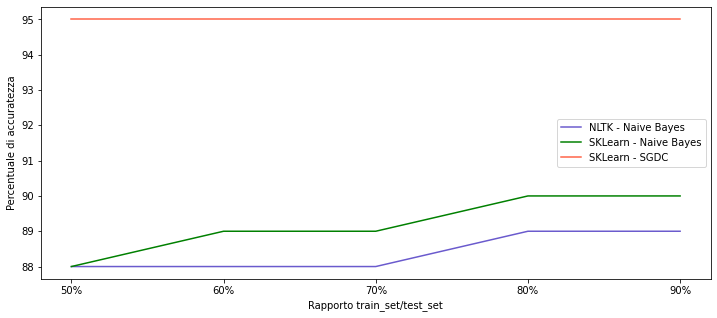

In [37]:
#raccolgo i valori
nltk_NB = {'50%':88, '60%':88, '70%':88, '80%':89, '90%':89}
sklearn_NB = {'50%':88, '60%':89, '70%':89, '80%':90, '90%':90}
sk_learn_SGDC = {'50%':95, '60%':95, '70%':95, '80%':95, '90%':95}

#plot
plt.figure(figsize=(12,5))

plt.errorbar(nltk_NB.keys(), nltk_NB.values(), color = 'slateblue')
plt.errorbar(sklearn_NB.keys(), sklearn_NB.values(), color = 'green')
plt.errorbar(sk_learn_SGDC.keys(), sk_learn_SGDC.values(), color = 'tomato')

plt.legend(['NLTK - Naive Bayes', 'SKLearn - Naive Bayes', 'SKLearn - SGDC'])

plt.xlabel('Rapporto train_set/test_set')
plt.ylabel('Percentuale di accuratezza')
plt.show();

- Con il metodo *Naive Bayes*, sia per l'implementazione in **NLTK** che per l'implementazione in **SKLearn**, si ha una percentuale di accuratezza pari a **~89%**. Nonostante questo, **SKLearn** risulta molto più efficiente nell'esecuzione delle fasi di training e testing
- Con il metodo *SGD Classifier* implementato nella libreria **SKLearn**, si ha una percentuale di accuratezza pari a **~95%**

<h3>Per questo problema si ottengono i risultati migliori utilizzando il metodo <i style="color:tomato;">SGD Classifier</i> implementato nella libreria <b style="color:tomato;">SKLearn</b>.

Con esso è possibile ottenere una percentuale di accuratezza di classificazione dei video pari a <b style="color:darkorange;">~95%</b>, valore notevolmente alto dato l'alto numero di classi totali (9) e la poca specificità dei titoli e delle descrizioni dei video su Youtube.

Questo è reso possibile anche grazie alle fasi di pulizia del testo e di stemming delle parole, ma anche grazie alle tecniche di *cross-validation* e *grid-search*.</h3>
